In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks/Rootee

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Rootee


In [10]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from scipy import signal
import cv2
import PIL
import glob
from PIL import Image
from cv2.ximgproc import guidedFilter
import time

def get_center_circle_coords(im, is_01_normalized: bool):
    start = time.time() #you can uncomment the below code for automatic coordinate finding, but it will take 2 seconds more
    '''
    A = np.dstack([
      signal.cspline2d(im[:,:,ch] * (255 if is_01_normalized else 1), 200.0)
      for ch in range(im.shape[-1])])
    min_r = int(min(im.shape[0], im.shape[1]) / 4)
    max_r = int(max(im.shape[0], im.shape[1]) / 4*3)
  
    try:
        circles = cv2.HoughCircles(
            (norm01(A).max(-1)*255).astype('uint8'), cv2.HOUGH_GRADIENT, .8,
            min(A.shape[:2]), param1=20, param2=50, minRadius=min_r, maxRadius=max_r)[0]
    except:
        print('center_crop_and_get_foreground_mask failed to get background - trying again with looser parameters')
        A2 = get_foreground_slow(im)
        
        circles = cv2.HoughCircles(
            (A2*255).astype('uint8'), cv2.HOUGH_GRADIENT, .8,
            min(A.shape[:2]), param1=20, param2=10, minRadius=min_r, maxRadius=max_r)[0]

    x, y, r = circles[circles[:, -1].argmax()].round().astype('int')
    end = time.time()
    print("get_center_coords: ", end - start)
    '''
    x,y=int(2458/2), int(2160/2) #these are the coordinates of the center in the resized image that you will do before you call this function
    r= int(2458/2)
    end = time.time()
    print("get_center_coords: ", end - start)
    return x,y,r

def get_foreground_mask_from_center_circle_coords(shape, x,y,r):
    start = time.time()
    mask = np.zeros(shape, dtype='uint8')
    cv2.circle(mask, (x, y), r, 255, cv2.FILLED)
    mask = mask.astype(bool)
    end = time.time()
    print("get_foreground_mask_from_center_circle_coords: ", end - start)
    return mask

def center_crop_and_get_foreground_mask(im, crop=True, is_01_normalized=True, center_circle_coords=None, label_img=None):
    start = time.time()
    if center_circle_coords is not None:
        x,y,r = center_circle_coords
    else:
        h, w, _ = im.shape
        x, y, r = get_center_circle_coords(im, is_01_normalized)
    mask = get_foreground_mask_from_center_circle_coords(im.shape[:2], x,y,r)
    if crop:
        crop_slice = np.s_[max(0, y-r):min(h,y+r),max(0,x-r):min(w,x+r)]
        rv = [im[crop_slice], mask[crop_slice]]
        if label_img is not None:
            rv.append(label_img[crop_slice])
    else:  # don't crop.  just get the mask.
        rv = [im, mask]
        if label_img is not None:
            rv.append(label_img[crop_slice])
    end = time.time()
    print("center_crop_and_get_foreground_mask: ", end - start)
    return rv

def get_background_slow(img):
    start = time.time()
    img = img/img.max()
    background = (img < 20/255)
    background = ndi.morphology.binary_closing(
        background, np.ones((5, 5, 1)))
    background |= np.pad(np.zeros(
        (background.shape[0]-6, background.shape[1]-6, 3), dtype='bool'),
        [(3, 3), (3, 3), (0, 0)], 'constant', constant_values=1)
    end = time.time()
    print("get_background_slow: ", end - start)
    return background.sum(2) == 3

def check_and_fix_nan(A, replacement_img):
    start = time.time()
    nanmask = np.isnan(A)
    if nanmask.any():
        #log.warn("sharpen: guided filter blurring operation or laplace filter returned nans. your input image has extreme values")
        A[nanmask] = replacement_img[nanmask]
    end = time.time()
    print("check_and_fix_nan: ",end - start)
    return A

def get_foreground_slow(img):
    return ~get_background_slow(img)

def norm01(img, background=None):
    start = time.time()
    if background is not None:
        tmp = img[~background]
        min_, max_ = tmp.min(), tmp.max()
    else:
        min_, max_ = img.min(), img.max()
    rv = (img - min_) / (max_ - min_)
    if background is not None:
        rv[background] = img[background]
    end = time.time()
    print("norm01: ", end - start)
    return rv

def sharpen(img, bg=None, t='laplace', blur_radius=30, blur_guided_eps=1e-8,
            use_guidedfilter='if_large_img'):
    start = time.time()
    if bg is None:
        bg = np.zeros(img.shape[:2], dtype='bool')
    else:
        img = img.copy()
        img[bg] = 0
        A = cv2.ximgproc.guidedFilter(
        img.astype('float32'),
        img.astype('float32'),
        blur_radius, blur_guided_eps)

    if t == 'laplace':
        t = 1-norm01(sharpen(ndi.morphological_laplace(
            img, (2,2,1), mode='wrap'), bg, 0.15), bg)
        
    if len(np.shape(t)) + 1 == len(img.shape):
        t_refined = np.expand_dims(t, -1).astype('float')
    else:
        t_refined = t
    if np.shape(t):
        t_refined[bg] = 1  # ignore background, but fix division by zero
    J = (
        img.astype('float')-A) / np.maximum(1e-8, np.maximum(t_refined, np.min(t_refined)/2)) + A
    #  assert np.isnan(J).sum() == 0
    if bg is not None:
        J[bg] = 0
    if use_guidedfilter == 'if_large_img':
        # note: at some point, find a better threshold?  This works.
        #1500
        use_guidedfilter = min(J.shape[0], J.shape[1]) >= 1500
    if not use_guidedfilter:
        J = check_and_fix_nan(J, img)
        return J

    r2 = cv2.ximgproc.guidedFilter(
        img.astype('float32'),
        J.astype('float32'),
        2, 1e-8)
    r2 = check_and_fix_nan(r2, img)
    if bg is not None:
        r2[bg] = 0
    end = time.time()
    print("sharpen: ", end - start)
    return r2

get_center_coords:  4.0531158447265625e-06
get_foreground_mask_from_center_circle_coords:  0.004530668258666992
center_crop_and_get_foreground_mask:  0.0057201385498046875
check_and_fix_nan:  0.00981450080871582
sharpen:  2.579524040222168
norm01:  0.23870015144348145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


check_and_fix_nan:  0.00926065444946289
sharpen:  6.123865842819214
total:  6.437808036804199


True

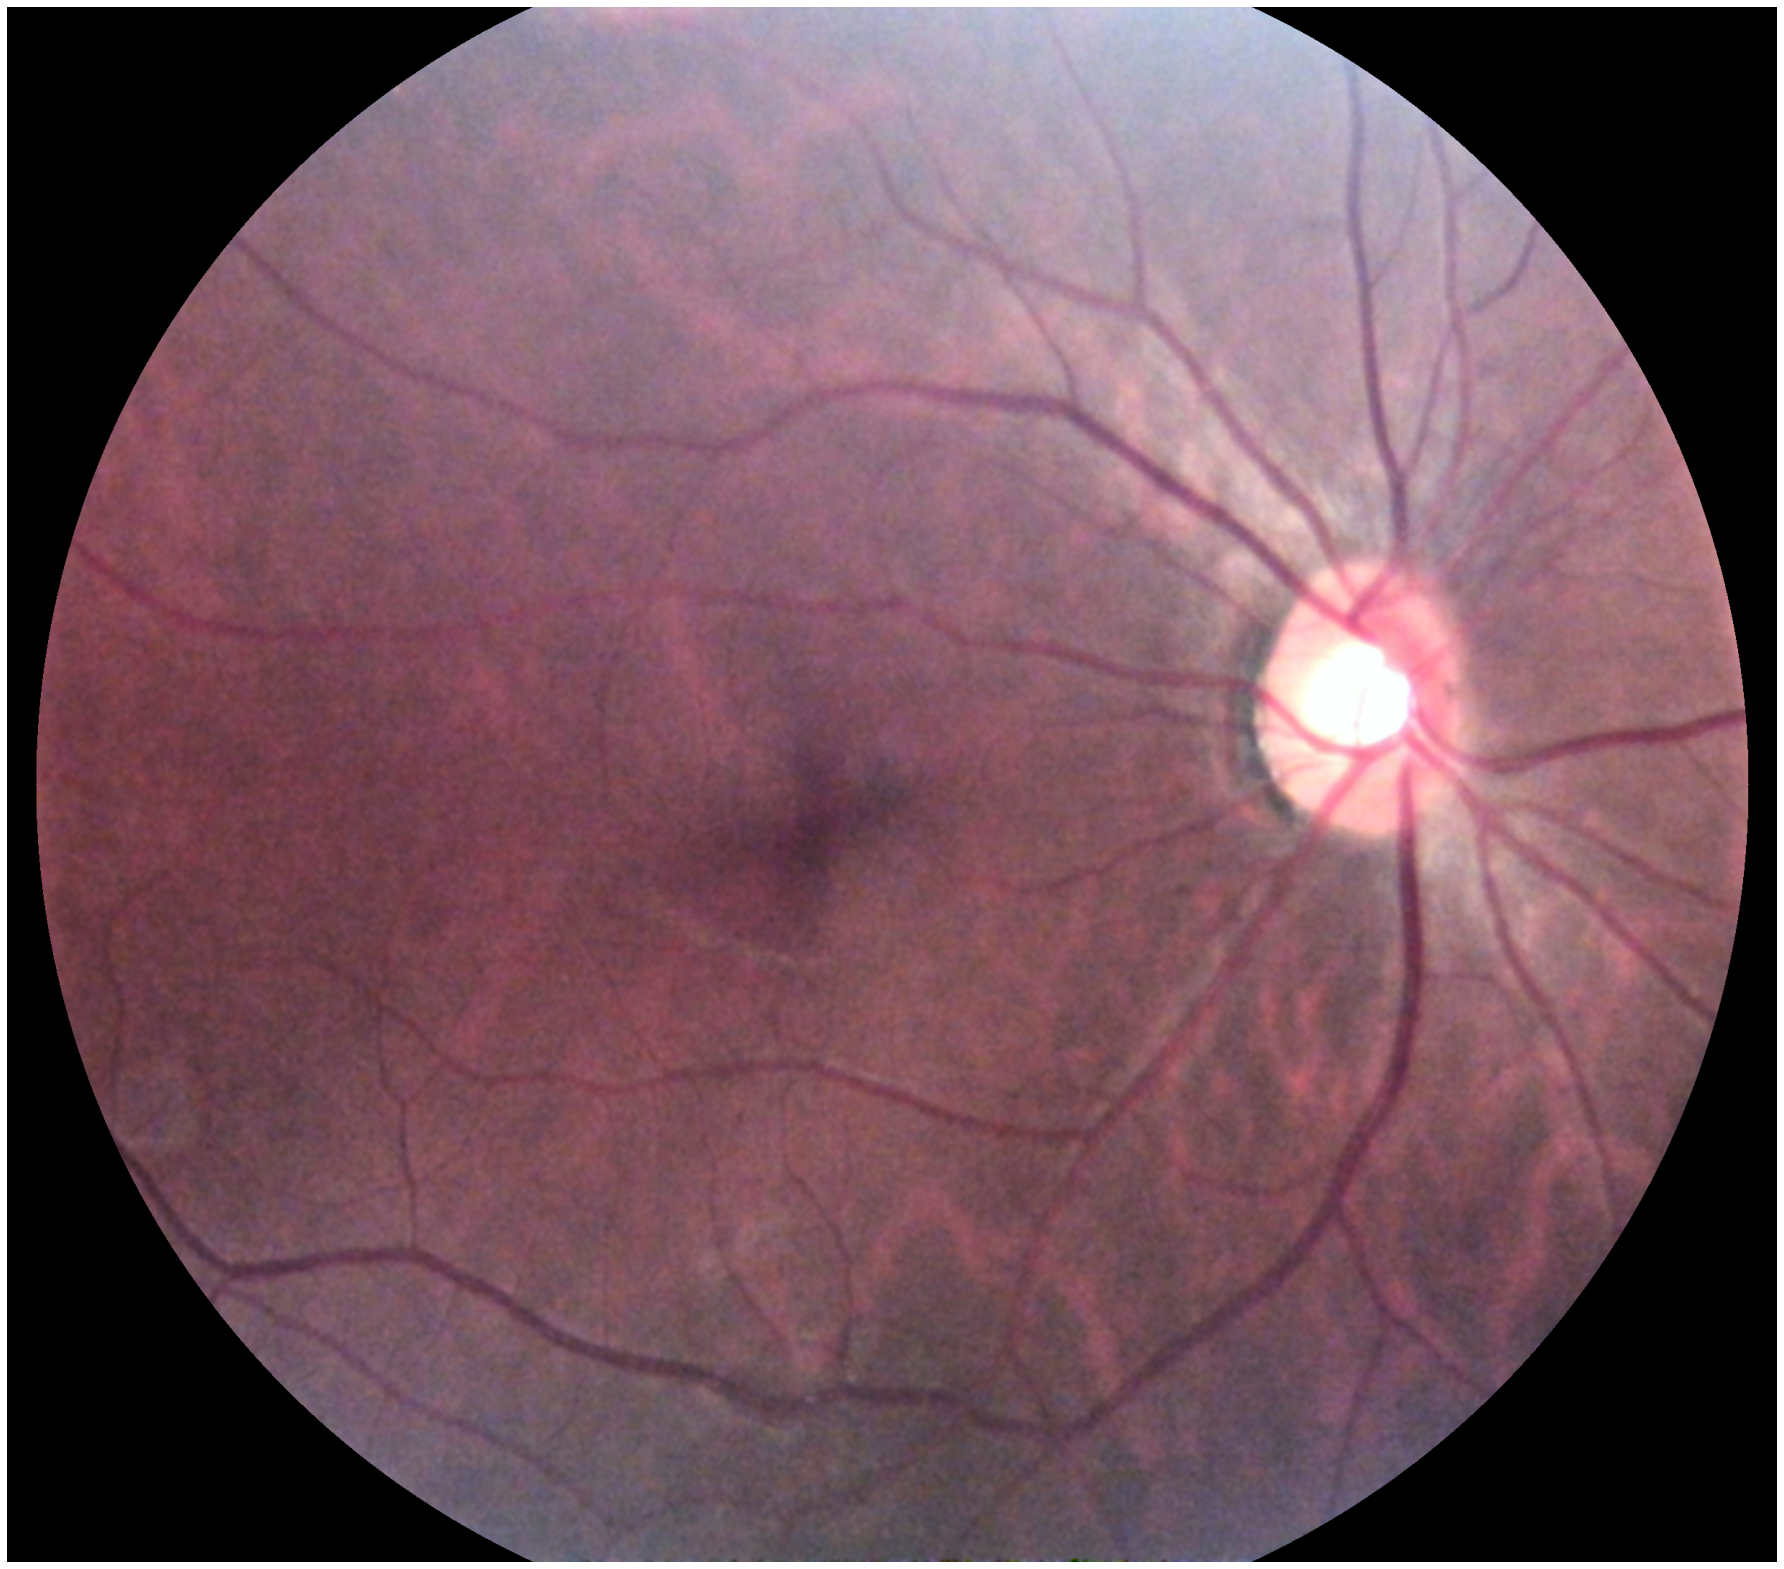

In [11]:
name='/content/drive/My Drive/Colab Notebooks/Rootee/Latest_image/3.jpg'
width= 2458  #width to resize for proper processing (include to avoid exceptions that may cause image to ignore some data)
height= 2160  #width to resize for proper processing (include to avoid exceptions)
start = time.time()
with PIL.Image.open(name) as img:
  img=img.resize((width,height))
  #img2=img
  #img.load()
  img = np.array(img) / 255

#I = img.copy()
I, fg = center_crop_and_get_foreground_mask(img)
enhanced_img2 = sharpen(I, bg=~fg)

#this part of the code will remove the outer lining of circle (white flashes)
h, w = enhanced_img2.shape[:2]
center = (int(w/2), int(h/2))
radius = w/2 - 40
Y, X = np.ogrid[:h, :w]
dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
mask = dist_from_center <= radius
enhanced_img2[~mask] = 0

end = time.time()
print("total: ", end - start)

fig = plt.figure()
fig.set_size_inches(width/100,height/100)
ax = plt.Axes(fig, [0., 0., 1., 1.])
plt.margins(0,0)
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(enhanced_img2, aspect='equal')
plt.savefig('/content/drive/My Drive/Colab Notebooks/Rootee/Latest_image/3pdef3.jpg', dpi=100,pad_inches=0, bbox_inches = 'tight')

img=cv2.imread(name)
imgnew= cv2.imread("/content/drive/My Drive/Colab Notebooks/Rootee/Latest_image/3pdef3.jpg")
imgnew=cv2.resize(imgnew, (2880,2160)) #resize to original shape
#final = np.hstack((img,imgnew))
cv2.imwrite('/content/drive/My Drive/Colab Notebooks/Rootee/Latest_image/3presizedef3.jpg', imgnew)